In [9]:
from src.utils import *
from src.models.gan import *
from src.models.vae import *
from src.models.ae import *
from src.pipeline.base_model import *
from src.pipeline.trainer import *
from src.data.cifar10 import *

import torch
from torch import nn

In [2]:
cifar10_data_module = CIFAR10DataModule(data_dir='./data', batch_size=64, val_split=0.2)
cifar10_data_module.setup()

print(f"Training set size: {len(cifar10_data_module.train_dataloader().dataset)}")
print(f"Validation set size: {len(cifar10_data_module.val_dataloader().dataset)}")
print(f"Test set size: {len(cifar10_data_module.test_dataloader().dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# GAN

In [26]:
class GANModule(BaseModel):
    def __init__(self, latent_dim, lr=2e-04, b1=0.5, b2=0.999):
        super().__init__()
        self.generator = Generator(latent_dim=latent_dim)
        self.discriminator = Discriminator()
        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2

        self.validation_z = torch.randn(8, latent_dim)
        self.example_input_array = torch.zeros(2, latent_dim)

    @staticmethod
    def adversarial_loss(y_hat, y):
        return nn.BCELoss()(y_hat, y)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        return {"generator": opt_g, "discriminator": opt_d}

    def training_step(self, batch, optimizers):
        # Extract optimizers
        optimizer_g = optimizers["generator"]
        optimizer_d = optimizers["discriminator"]

        # Prepare real data and labels
        real_data = batch[0].to(self.device)
        batch_size = real_data.size(0)
        real_labels = torch.ones(batch_size, device=self.device, dtype=torch.float)
        fake_labels = torch.zeros(batch_size, device=self.device, dtype=torch.float)

        # Discriminator training: Real data
        self.discriminator.zero_grad()
        real_output = self.discriminator(real_data)
        d_loss_real = self.adversarial_loss(real_output, real_labels)
        d_loss_real.backward()

        # Discriminator training: Fake data
        noise = torch.randn(batch_size, self.latent_dim, 1, 1, device=self.device, dtype=torch.float)
        fake_data = self.generator(noise)
        fake_output = self.discriminator(fake_data.detach())  # Detach to prevent gradients from affecting the generator
        d_loss_fake = self.adversarial_loss(fake_output, fake_labels)
        d_loss_fake.backward()

        # Update the discriminator
        d_loss_total = d_loss_real + d_loss_fake
        optimizer_d.step()

        # Generator training
        self.generator.zero_grad()
        generator_output = self.discriminator(fake_data)  # No detach; gradients should flow back to the generator
        g_loss = self.adversarial_loss(generator_output, real_labels)  # Use real labels for generator loss
        g_loss.backward()

        # Update the generator
        optimizer_g.step()

        # Return losses and diagnostics
        return {
            "g_loss": g_loss.item(),
            "d_loss": d_loss_total.item(),
            "loss": g_loss.item() + d_loss_total.item()
        }

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        z = torch.randn(imgs.shape[0], self.latent_dim, 1, 1, device=self.device)
        generated_imgs = self.generator(z)

        # Validation loss: how well discriminator identifies real vs fake
        valid = torch.ones(imgs.size(0), device=self.device)
        fake = torch.zeros(imgs.size(0), device=self.device)

        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)
        fake_loss = self.adversarial_loss(self.discriminator(generated_imgs), fake)

        val_loss = (real_loss + fake_loss) / 2
        return {"loss": val_loss.item()}



In [27]:
gan_model = GANModule(latent_dim=100)

gan_trainer = Trainer(
    model=gan_model,
    data_module=cifar10_data_module,
    log_dir='./tensorboard/gan_logs',
    checkpoint_dir='./tensorboard/gan_checkpoints',
    device=device)

In [28]:
gan_trainer.train(num_epochs=20)

Epoch 0: Train Metrics = {'g_loss': 2.1889157576560976, 'd_loss': 1.0753795506954194, 'loss': 3.264295308351517}
Epoch 0: Val Metrics = {'loss': 0.5669524282406849}
Best model saved at epoch 0 with loss: 0.5669524282406849
Epoch 1: Train Metrics = {'g_loss': 1.7447658639907837, 'd_loss': 1.1058362254142762, 'loss': 2.8506020894050597}
Epoch 1: Val Metrics = {'loss': 0.532854612276053}
Best model saved at epoch 1 with loss: 0.532854612276053
Epoch 2: Train Metrics = {'g_loss': 1.4809638078689575, 'd_loss': 1.1886069105148316, 'loss': 2.669570718383789}
Epoch 2: Val Metrics = {'loss': 0.5760768913918999}
Epoch 3: Train Metrics = {'g_loss': 1.683794509124756, 'd_loss': 1.1365073493480682, 'loss': 2.820301858472824}
Epoch 3: Val Metrics = {'loss': 0.7340582434538823}
Epoch 4: Train Metrics = {'g_loss': 1.8953389151096345, 'd_loss': 1.0615629418849946, 'loss': 2.956901856994629}
Epoch 4: Val Metrics = {'loss': 0.5314764771491859}
Best model saved at epoch 4 with loss: 0.5314764771491859
Epo

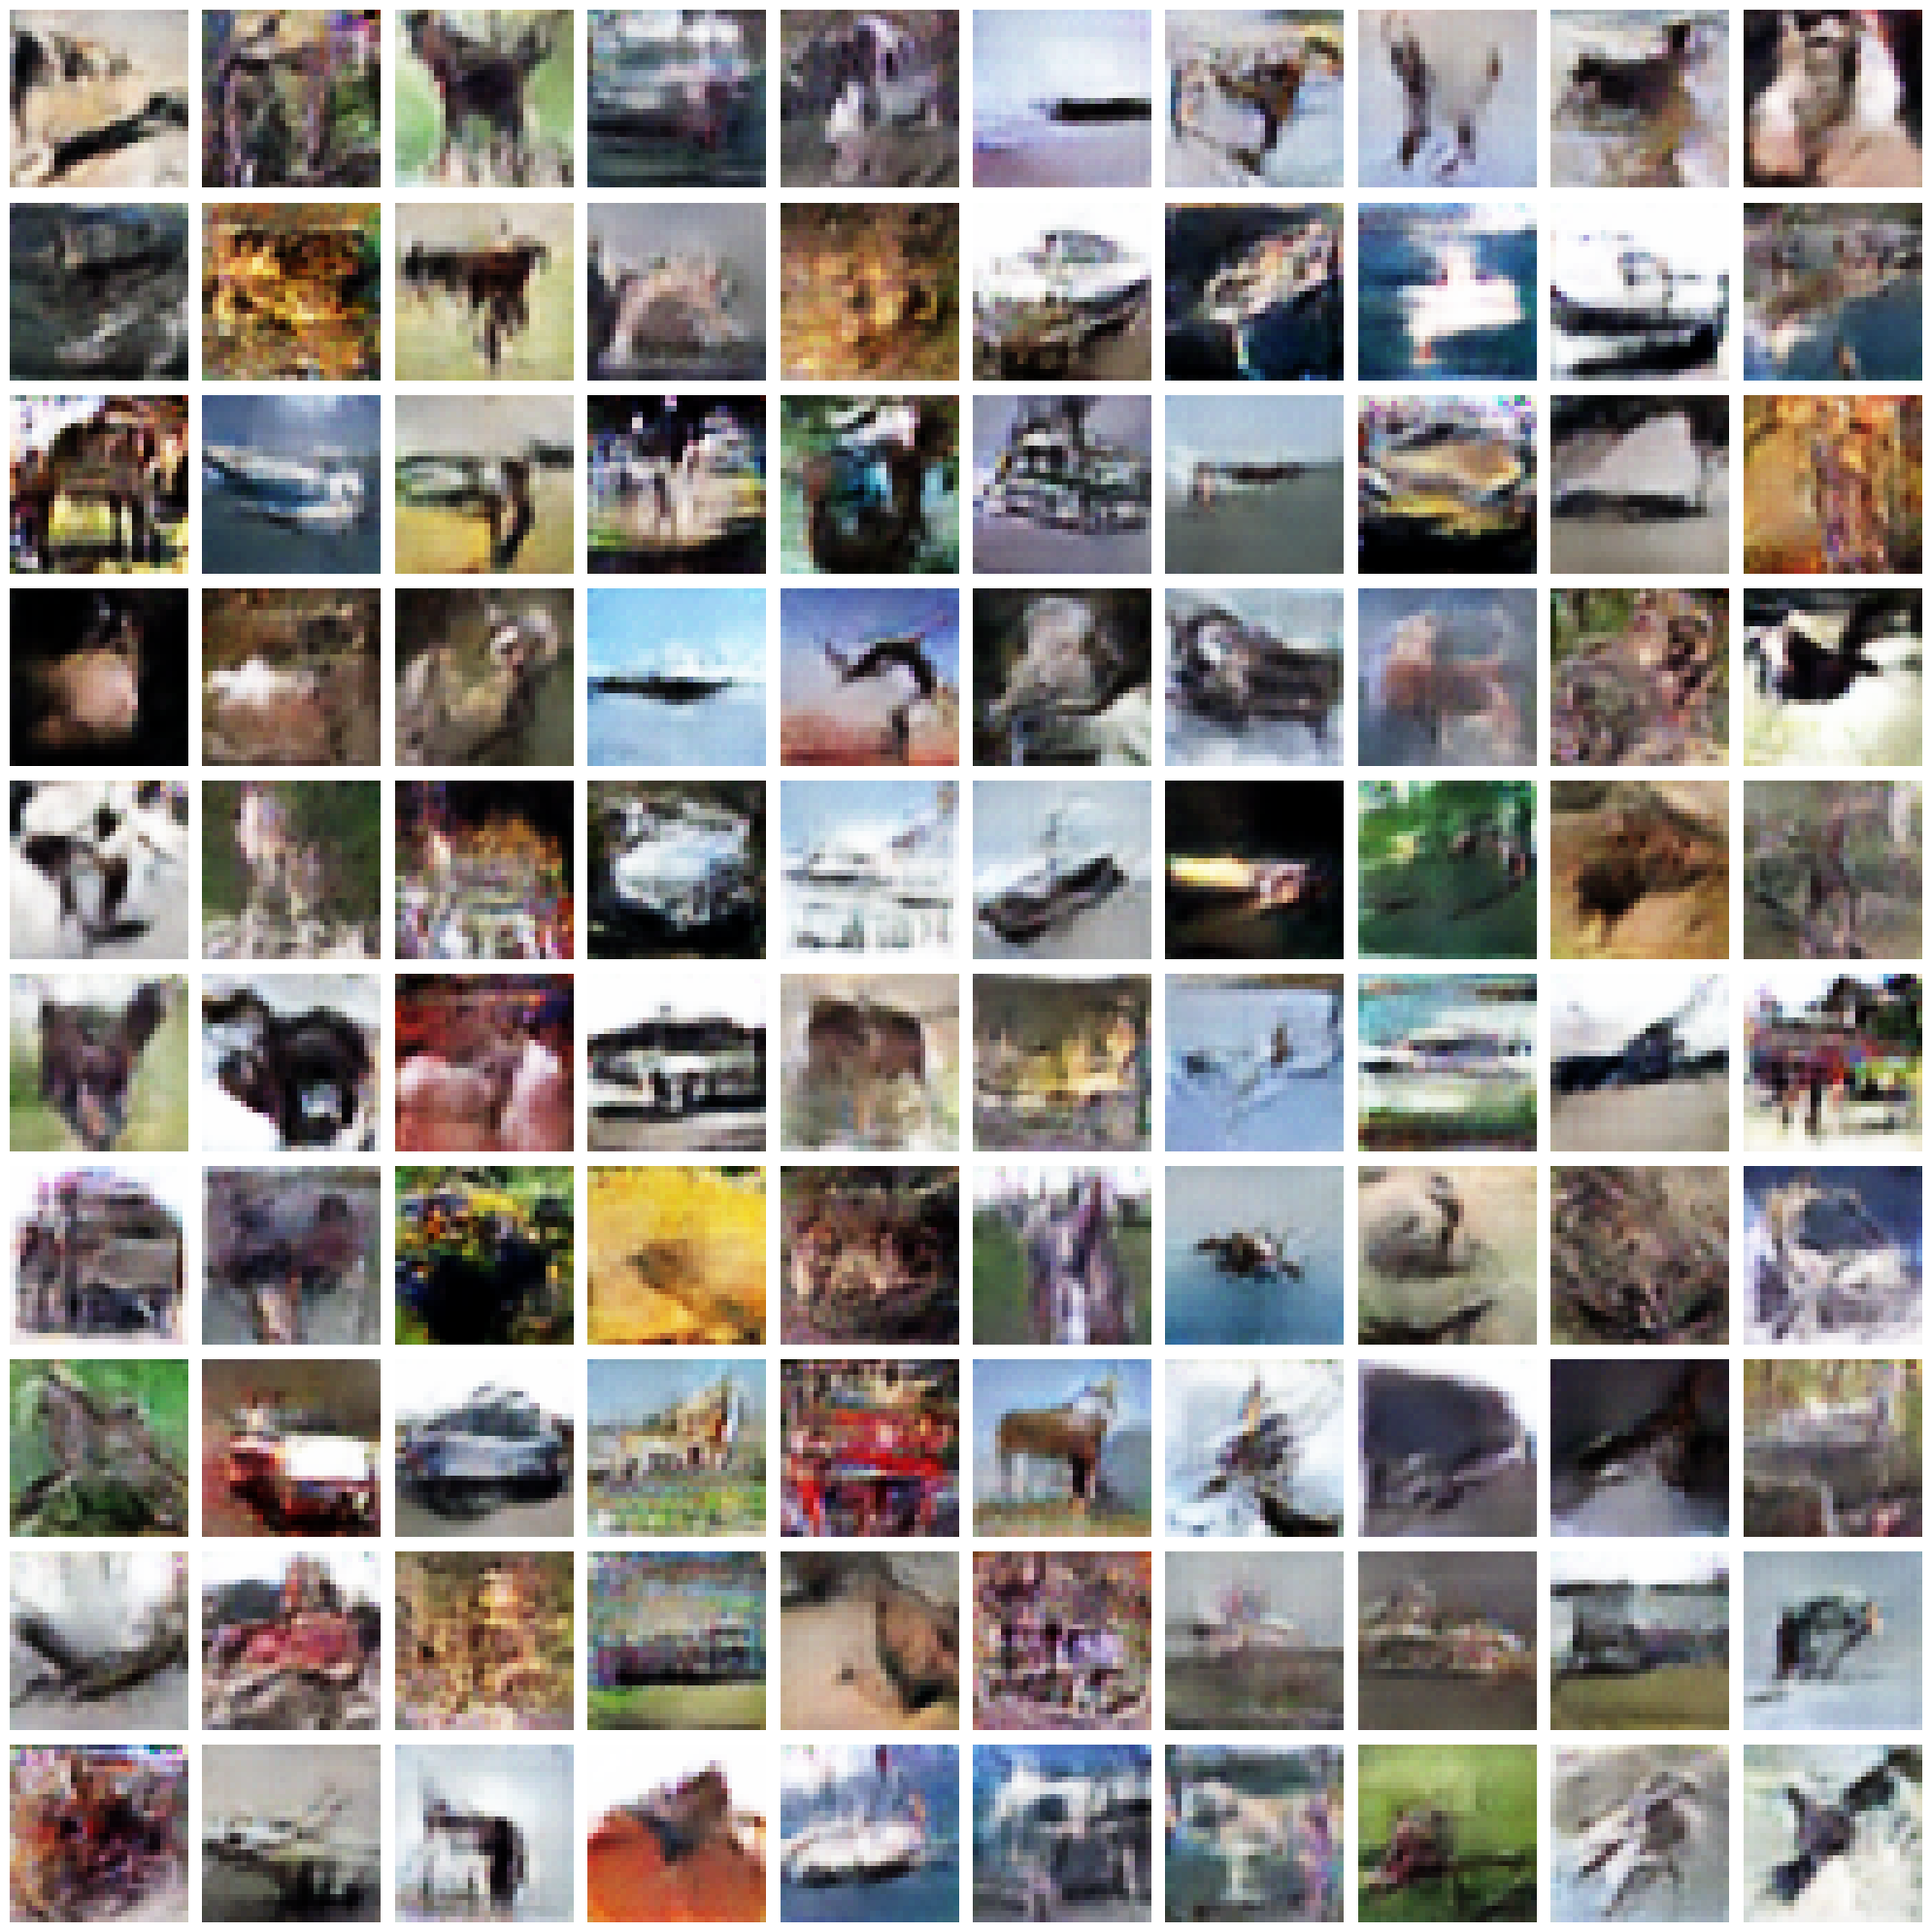

In [29]:
sample(gan_model.generator, num_samples=100, shape=(100, 1, 1), device=device, show=True)
pass

# VAE

In [4]:
import torch.nn.functional as F


class VAEModule(BaseModel):
    def __init__(self, latent_dim=128, lr=1e-3, beta=0.1):
        super().__init__()
        self.vae_model = VariationalAutoEncoder(latent_dim=latent_dim)
        self.latent_dim = latent_dim
        self.lr = lr
        self.beta = beta

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.vae_model.parameters(), lr=self.lr)
        return {"vae_optimizer": optimizer}

    @staticmethod
    def loss_function(outputs, targets, beta=0.1):
        recon_x, mu, logvar = outputs
        x = targets
        BCE = F.binary_cross_entropy(recon_x.view(-1, 3 * 32 * 32), x.view(-1, 3 * 32 * 32), reduction='sum')
        KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
        total_loss = BCE + beta * KL
        return total_loss

    def training_step(self, batch, optimizers):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        optimizer = optimizers["vae_optimizer"]

        # Forward pass
        outputs = self.vae_model(imgs)
        loss = self.loss_function(outputs, imgs, beta=self.beta)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return {"loss": loss.item()}

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        # Forward pass
        outputs = self.vae_model(imgs)
        loss = self.loss_function(outputs, imgs, beta=self.beta)

        return {"loss": loss.item()}


In [5]:
vae_model = VAEModule(latent_dim=128)

vae_trainer = Trainer(
    model=vae_model,
    data_module=cifar10_data_module,
    log_dir='./tensorboard/vae_logs',
    checkpoint_dir='./tensorboard/vae_checkpoints',
    device=device)

In [8]:
vae_trainer.train(num_epochs=50)

Epoch 50: Train Metrics = {'loss': 111859.41815}
Epoch 50: Val Metrics = {'loss': 111430.25110718551}
Best model saved at epoch 50 with loss: 111430.25110718551
Epoch 51: Train Metrics = {'loss': 111848.1671375}
Epoch 51: Val Metrics = {'loss': 111425.17156399283}
Best model saved at epoch 51 with loss: 111425.17156399283
Epoch 52: Train Metrics = {'loss': 111844.322}
Epoch 52: Val Metrics = {'loss': 111420.37895601115}
Best model saved at epoch 52 with loss: 111420.37895601115
Epoch 53: Train Metrics = {'loss': 111834.930425}
Epoch 53: Val Metrics = {'loss': 111429.11348029459}
Epoch 54: Train Metrics = {'loss': 111828.4260125}
Epoch 54: Val Metrics = {'loss': 111402.75408041402}
Best model saved at epoch 54 with loss: 111402.75408041402
Epoch 55: Train Metrics = {'loss': 111836.50985}
Epoch 55: Val Metrics = {'loss': 111462.09668590764}
Epoch 56: Train Metrics = {'loss': 111824.8448875}
Epoch 56: Val Metrics = {'loss': 111404.44051054936}
Epoch 57: Train Metrics = {'loss': 111817.648

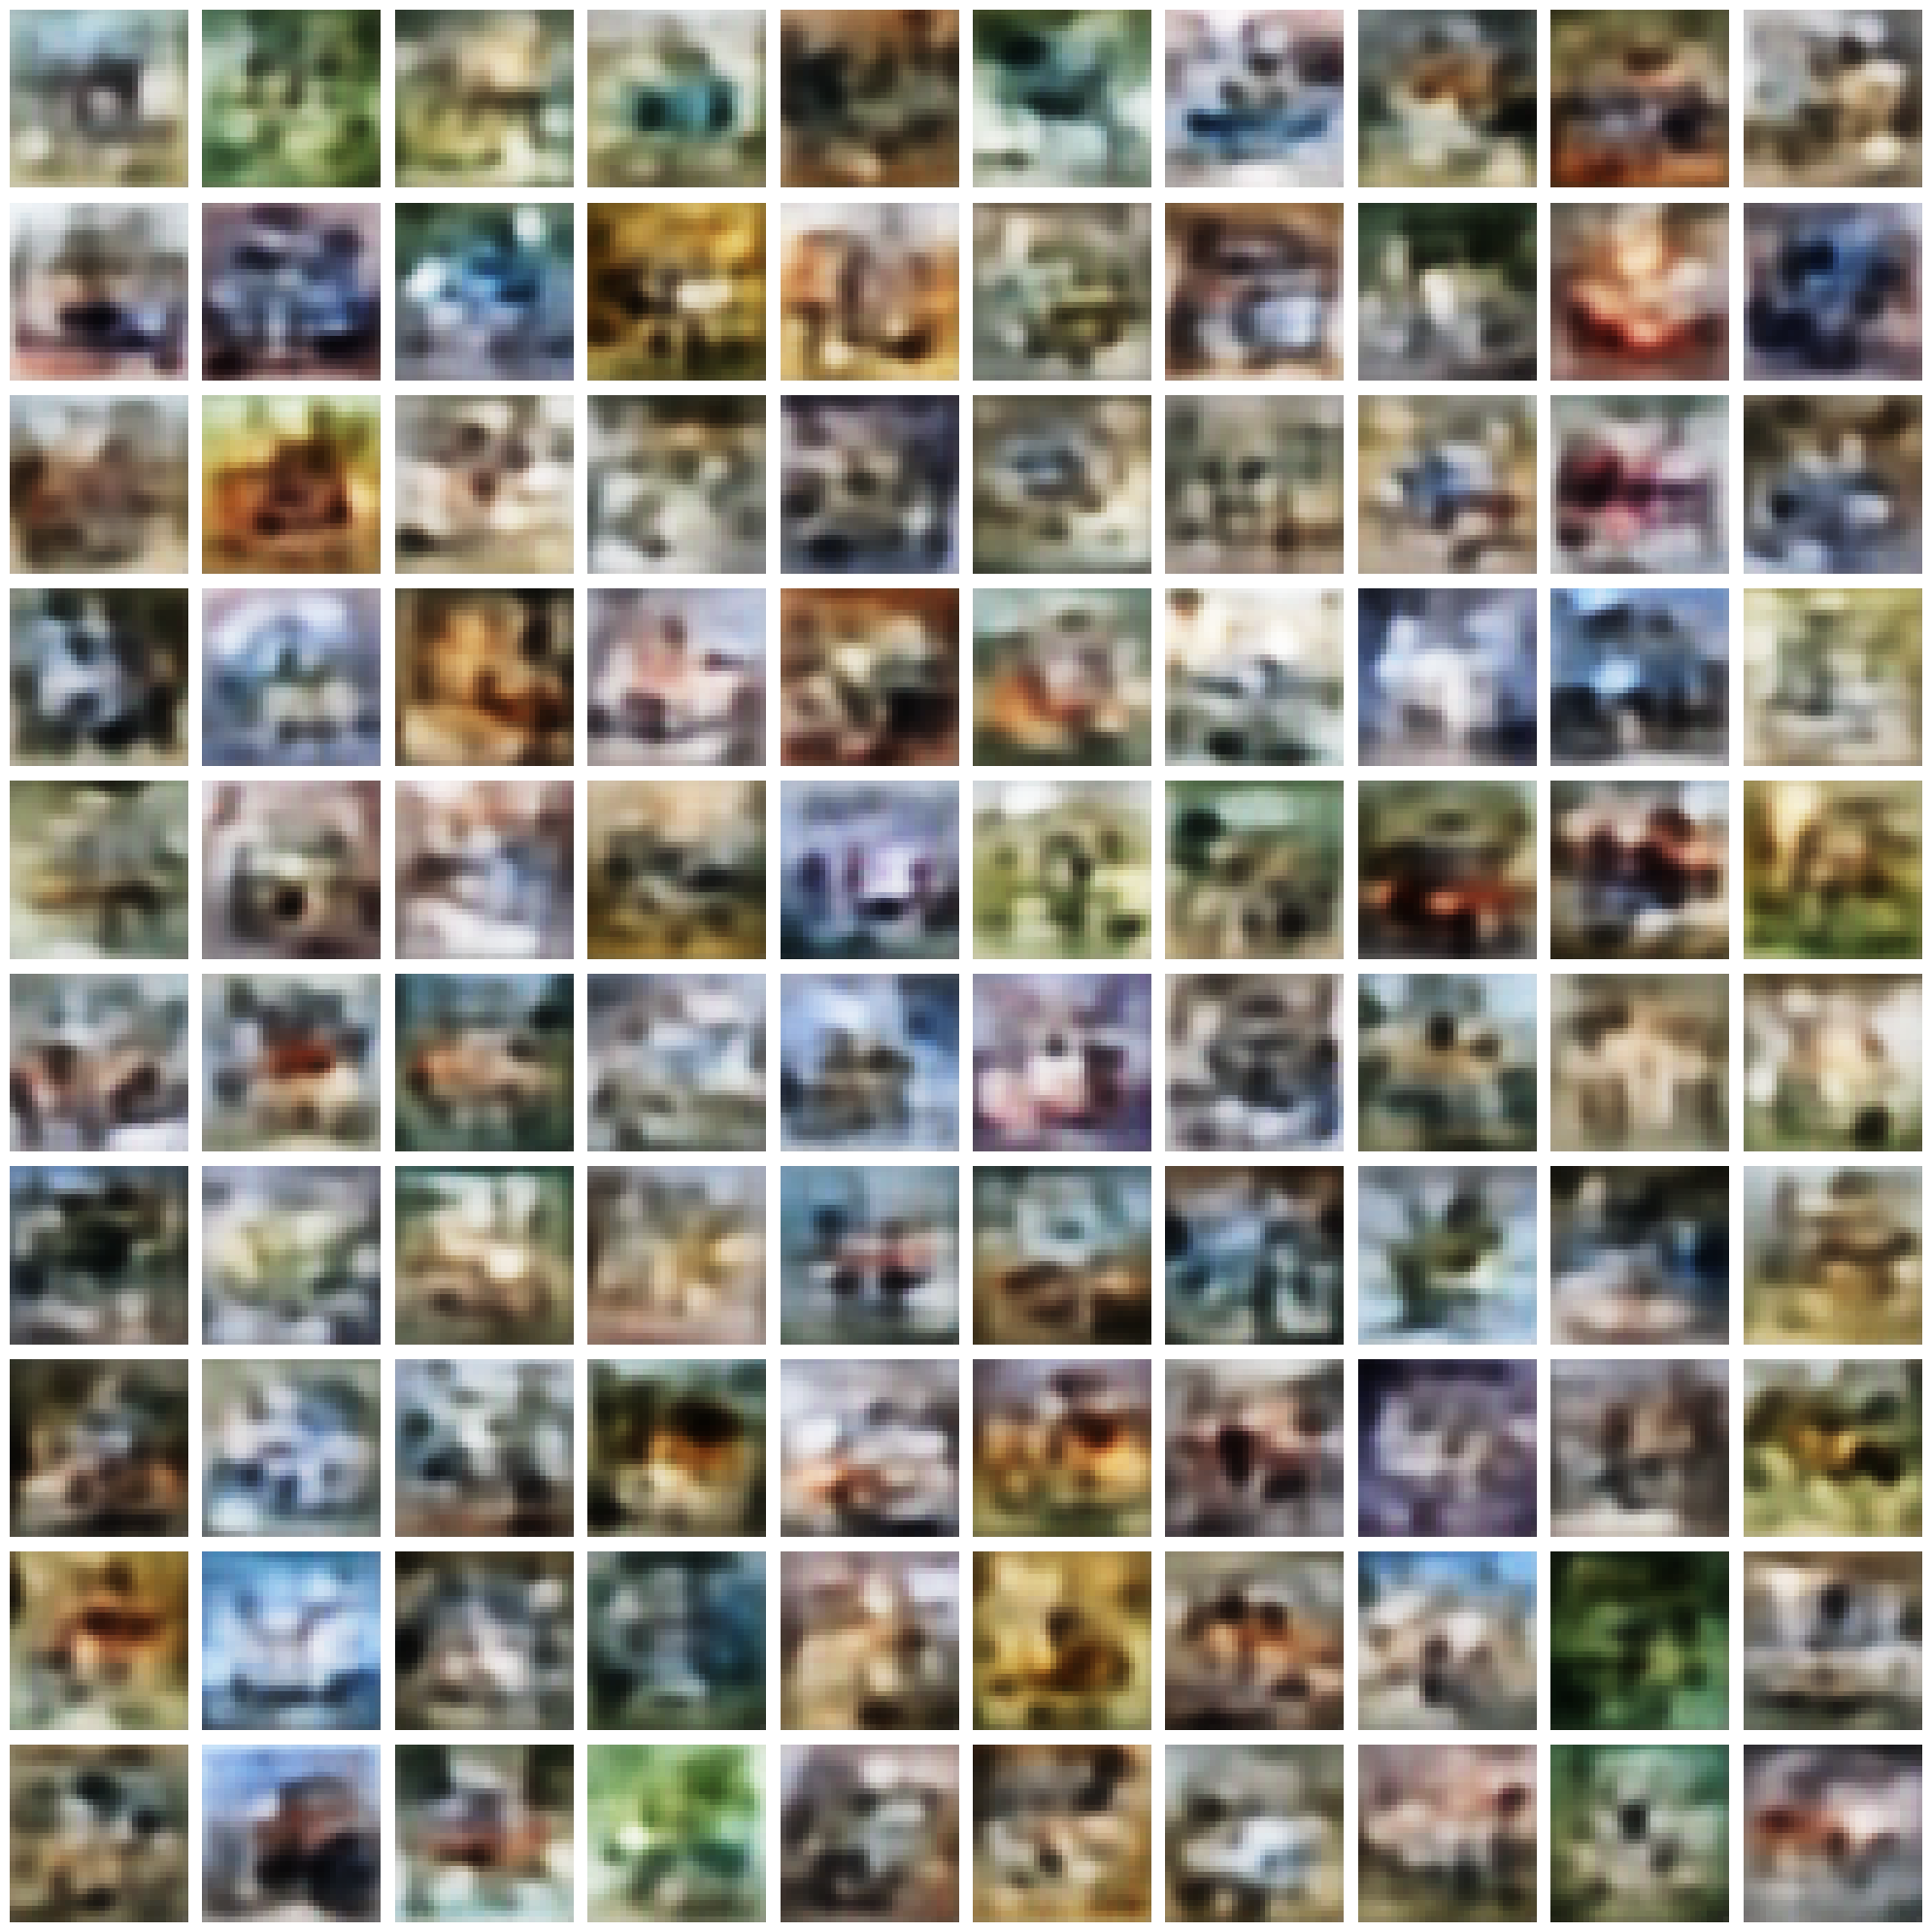

''

In [7]:
sample(vae_model.vae_model.decode, 100, shape=(128,), device=device, show=True)
_

# AE

In [20]:
class AEModule(BaseModel):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.ae_model = AutoEncoder()
        self.lr = lr
        self.loss_function = nn.MSELoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.ae_model.parameters(), lr=self.lr)
        return {"ae_optimizer": optimizer}

    def training_step(self, batch, optimizers):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        optimizer = optimizers["ae_optimizer"]

        # Forward pass
        outputs = self.ae_model(imgs)
        loss = self.loss_function(outputs, imgs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return {"loss": loss.item()}

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        # Forward pass
        outputs = self.ae_model(imgs)
        loss = self.loss_function(outputs, imgs)

        return {"loss": loss.item()}


In [21]:
ae_model = AEModule(lr=5e-4)

ae_trainer = Trainer(
    model=ae_model,
    data_module=cifar10_data_module,
    log_dir='./tensorboard/ae_logs',
    checkpoint_dir='./tensorboard/ae_checkpoints',
    device=device)

In [24]:
ae_trainer.train(num_epochs=10)

Epoch 10: Train Metrics = {'loss': 0.004737638979405164}
Epoch 10: Val Metrics = {'loss': 0.0046463556762689805}
Best model saved at epoch 10 with loss: 0.0046463556762689805
Epoch 11: Train Metrics = {'loss': 0.004571402657032013}
Epoch 11: Val Metrics = {'loss': 0.004456582843996347}
Best model saved at epoch 11 with loss: 0.004456582843996347
Epoch 12: Train Metrics = {'loss': 0.004431726246327162}
Epoch 12: Val Metrics = {'loss': 0.004325185886103731}
Best model saved at epoch 12 with loss: 0.004325185886103731
Epoch 13: Train Metrics = {'loss': 0.004302459747716784}
Epoch 13: Val Metrics = {'loss': 0.004193132114448365}
Best model saved at epoch 13 with loss: 0.004193132114448365
Epoch 14: Train Metrics = {'loss': 0.004179932615160942}
Epoch 14: Val Metrics = {'loss': 0.004088771062351431}
Best model saved at epoch 14 with loss: 0.004088771062351431
Epoch 15: Train Metrics = {'loss': 0.004071146088838577}
Epoch 15: Val Metrics = {'loss': 0.003996776025386373}
Best model saved at e

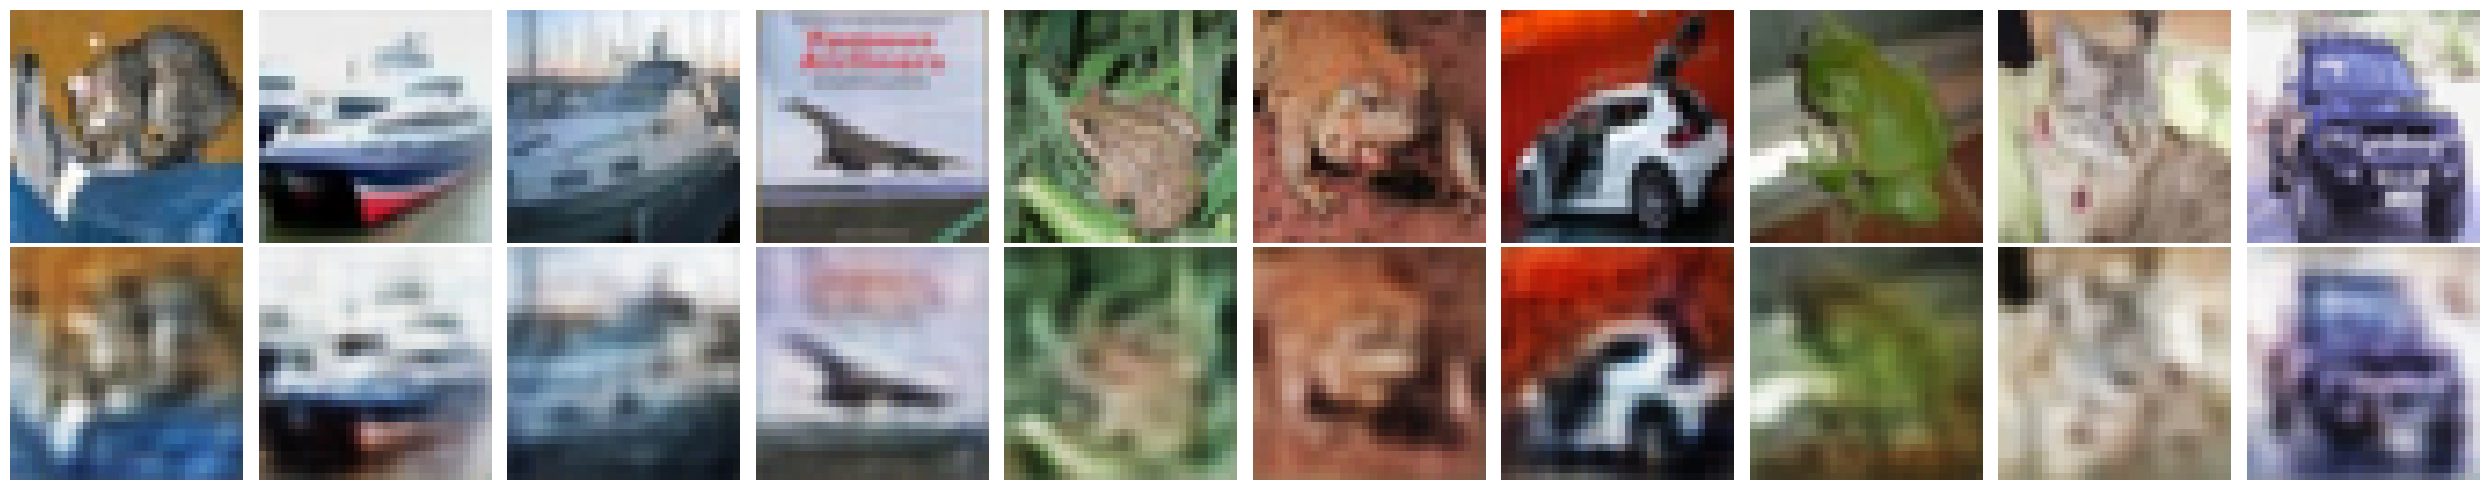

In [25]:
visualize_reconstructions(ae_model.ae_model, cifar10_data_module.test_dataloader(), device=device)